In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
import xgboost as xgb
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.DataFrame.from_csv("train.csv",index_col=None)

In [3]:
train.shape

(188318, 132)

In [4]:
train.columns[1:117]

Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cat107', u'cat108', u'cat109', u'cat110', u'cat111', u'cat112',
       u'cat113', u'cat114', u'cat115', u'cat116'],
      dtype='object', length=116)

In [4]:
train_encode = train[["cat80","cat87","cat57","cat12","cat79","cat10","cat7","cat89","cat2","cat72", \
             "cat81","cat11","cat1","cat13","cat9","cat3","cat16","cat90","cat23","cat36", \
             "cat73","cat103","cat40","cat28","cat111","cat6","cat76","cat50","cat5", \
             "cat4","cat14","cat38","cat24","cat82","cat25"]]

In [5]:
train_encode = train.ix[:, 1:117]

In [5]:
train_encode[:2]

,cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,...,cat6,cat76,cat50,cat5,cat4,cat14,cat38,cat24,cat82,cat25
0,D,B,A,A,B,A,A,A,B,A,...,A,A,A,A,B,A,A,A,B,A
1,D,B,A,A,B,B,A,A,B,A,...,A,A,A,A,A,A,A,A,A,A


### лэйбл энкодинг

In [134]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [163]:
le = MultiColumnLabelEncoder()
le.fit(train_encode)

<__main__.MultiColumnLabelEncoder instance at 0x7f23c9c761b8>

In [164]:
train_encode = le.transform(train_encode)

In [39]:
#train_encode = MultiColumnLabelEncoder(columns = train_encode.columns).fit_transform(train_encode)

### onehot

In [6]:
train_encode = pd.get_dummies(train_encode[:])


In [3]:
y = train.loss
y = pd.DataFrame(y)

#train_encode = train_encode.drop('loss', axis=1)

In [8]:
train.columns[117:132]

Index([u'cont1', u'cont2', u'cont3', u'cont4', u'cont5', u'cont6', u'cont7',
       u'cont8', u'cont9', u'cont10', u'cont11', u'cont12', u'cont13',
       u'cont14', u'loss'],
      dtype='object')

In [9]:
train_encode =  pd.concat([train_encode, train.ix[:, 117:131]],axis=1)

In [10]:
train_encode = train_encode.reindex_axis(sorted(train_encode.columns), axis=1)

In [11]:
train_encode[:2]

,cat103_A,cat103_B,cat103_C,cat103_D,cat103_E,cat103_F,cat103_G,cat103_H,cat103_I,cat103_J,...,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9
0,1,0,0,0,0,0,0,0,0,0,...,0.822493,0.714843,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135
1,1,0,0,0,0,0,0,0,0,0,...,0.611431,0.304496,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127


In [4]:
log_y = np.log(y + 200)

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_encode, y)
train_scaled = scaler.transform(train_encode)
train_scaled = pd.DataFrame(train_scaled)

In [27]:
test_scaled = scaler.transform(test_encode)
test_scaled = pd.DataFrame(test_scaled)

In [121]:
cols = train.columns
import seaborn as sns
#Plot count plot for all attributes in a 29x4 grid
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

NameError: name 'plt' is not defined

### Допфичи

In [63]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(train_encode, log_y, 
                                                                                     test_size = 0.3)

## графики

Populating the interactive namespace from numpy and matplotlib


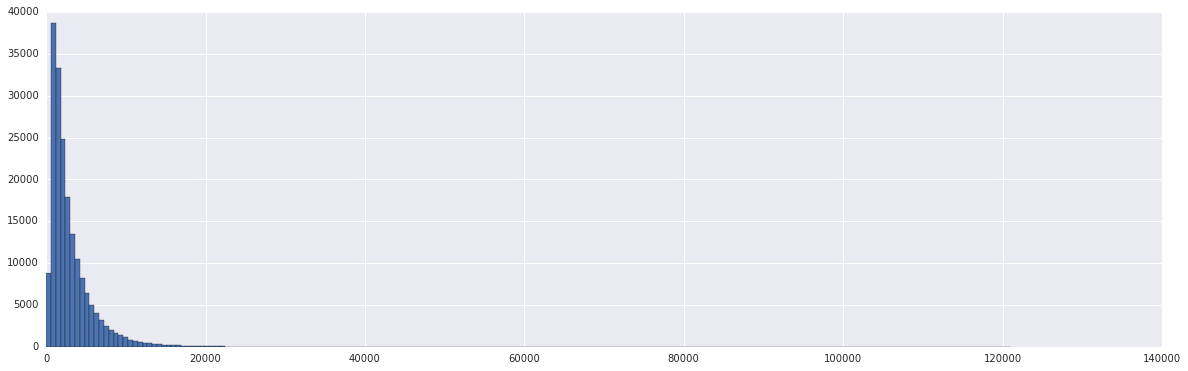

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.figure(figsize=(20, 6))
plt.hist(y, bins=200)
plt.show()

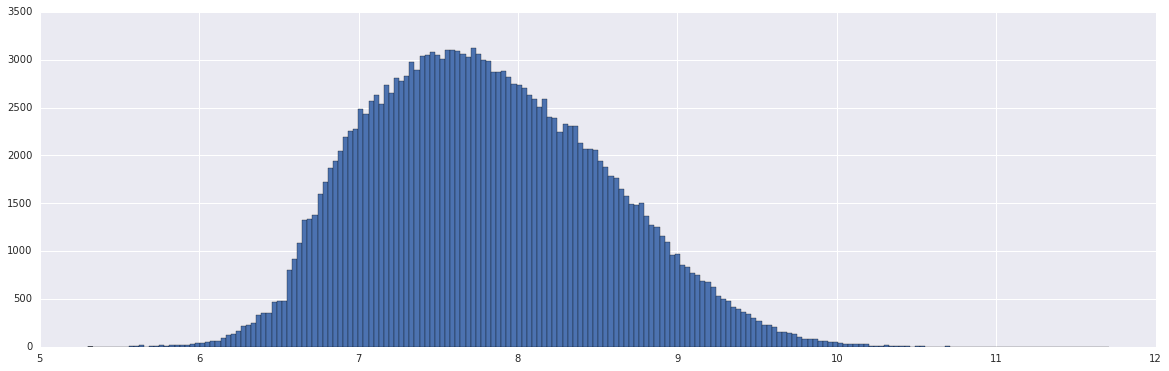

In [76]:
pylab.figure(figsize=(20, 6))
plt.hist(log_y, bins=200)
plt.show()

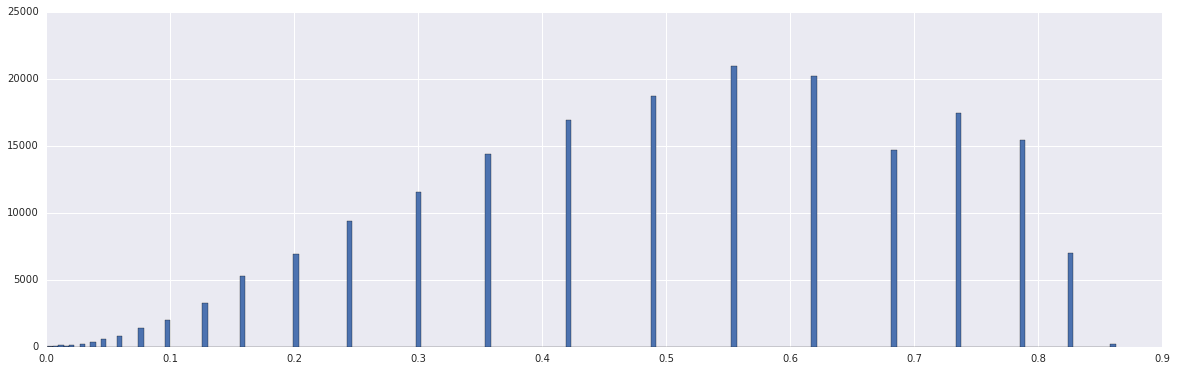

In [77]:
pylab.figure(figsize=(20, 6))
plt.hist(train_encode.cont2, bins=200)
plt.show()

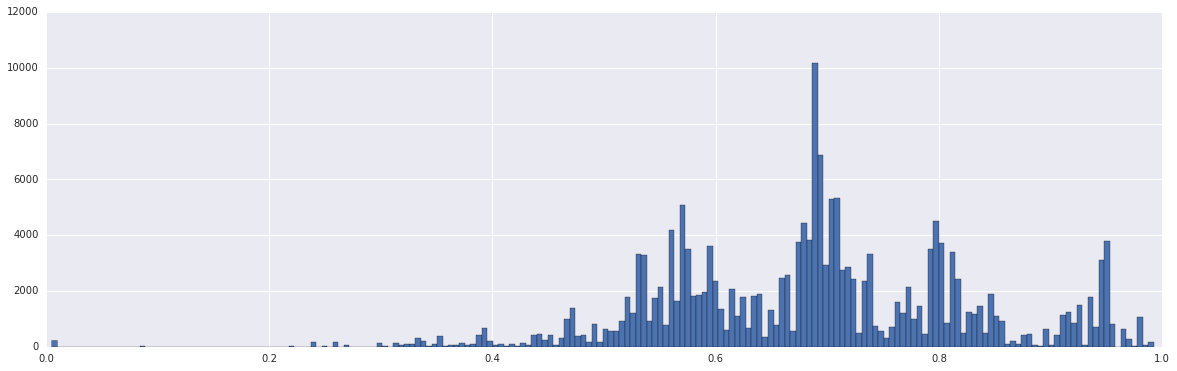

In [100]:
pylab.figure(figsize=(20, 6))
plt.hist(np.sqrt(train_encode.cont1+0.00001), bins=200)
plt.show()

## Линия

In [83]:
from sklearn import ensemble, linear_model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
pred_linear = linear_regressor.predict(test_data)

In [40]:
tr = np.exp(pred_linear)

In [92]:
pred_linear.max()

2433109093623.6826

In [ ]:
mean_absolute_error(np.exp(test_labels) - 200, np.exp(pred_linear+2433109093623) - 200)

## Буст

In [65]:
dtrain = xgb.DMatrix(data = train_data, label = train_labels)

In [66]:
param = {'min_child_weight': 100,
        'eta': 0.03,
        'colsample_bytree': 0.7,
        'max_depth': 12,
        'subsample': 0.7,
        'alpha': 1,
        'gamma': 1,
        'silent': 1,
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 1300



#5 - 1170
#6 - 1166
#7 - 1164
#8 - 1168
#10 - 1167
#12 - 1169

In [67]:
bst = xgb.train(param, dtrain, num_round)

In [68]:
boost_pred = bst.predict(xgb.DMatrix(data = test_data))

In [69]:
mean_absolute_error(np.exp(test_labels) - 200, np.exp(boost_pred) - 200)

1199.6017321245815

In [94]:
pd.DataFrame(bst.get_fscore().items()).sort_values(1, ascending=False)[:10]

,0,1
36,cont14,10703
62,cont7,6249
63,cont6,3883
342,cont8,3465
64,cont1,3390
67,cont2,3257
39,cont13,3098
61,cont4,3081
60,cont5,3042
66,cont3,2950


In [244]:
#1133.58  12

In [71]:
1135

1135

## Random Forest

In [101]:
forest_regressor = ensemble.RandomForestRegressor(n_estimators=25,
                                                  criterion='mse',
                                                  max_depth=15,
                                                  min_samples_split=2,
                                                  min_samples_leaf=1,
                                                  min_weight_fraction_leaf=0.0,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  bootstrap=True,
                                                  oob_score=False,
                                                  n_jobs=1,
                                                  random_state=None,
                                                  verbose=0)
forest_regressor.fit(train_data, train_labels)
random_forest_prediction = forest_regressor.predict(test_data)

In [102]:
mean_absolute_error(np.exp(test_labels) - 200, np.exp(random_forest_prediction) - 200)

1232.0434714974645

# Модели 1го уровня

In [44]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesClassifier

class ProbaEstimator(BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit(self, X, y):
        self.estimator.fit(X, y)
    def predict(self, X):
        return self.estimator.predict_proba(X)

cv = KFold(train.shape[0], n_folds=5, random_state=42)

## Random forest

In [74]:
forest_regressor = ensemble.RandomForestRegressor(n_estimators=25,
                                                  criterion='mse',
                                                  max_depth=15,
                                                  min_samples_split=2,
                                                  min_samples_leaf=1,
                                                  min_weight_fraction_leaf=0.0,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  bootstrap=True,
                                                  oob_score=False,
                                                  n_jobs=1,
                                                  random_state=None,
                                                  verbose=0)


preds_train = np.exp(model_selection.cross_val_predict(forest_regressor, train_encode, log_y, cv=cv, method='predict')) - 200
preds_test = np.exp(forest_regressor.fit(train_encode, log_y).predict(test_encode)) - 200

preds_train = pd.DataFrame(preds_train, columns = ['loss'])
preds_test = pd.DataFrame(preds_test, columns = ['loss'])

preds_train.to_csv('stack/forest_train.csv', index=False)
preds_test.to_csv('stack/forest_test.csv', index=False)

#np.savetxt('/stack/forest_train.csv', preds_train)
#np.savetxt('/stack/forest_test.csv', preds_test)


## Бустинг 1

In [28]:
from sklearn.cross_validation import KFold
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesClassifier

boost_regressor = xgb.XGBRegressor(max_depth=12,
                                   learning_rate=0.03,
                                   n_estimators=1300,
                                   #silent=True,
                                   objective='reg:linear',
                                   #nthread=-1,
                                   #gamma=0,
                                   min_child_weight=100,
                                   #max_delta_step=0,
                                   subsample=0.7,
                                   colsample_bytree=0.7,
                                   colsample_bylevel=0.7,
                                   #reg_alpha=0,
                                   #reg_lambda=1,
                                   #scale_pos_weight=1,
                                   #base_score=0.5,
                                   #seed=0,
                                   #missing=None
                                  )

preds_train = np.exp(sklearn.model_selection.cross_val_predict(boost_regressor, train_encode, log_y, cv=cv, method='predict')) - 200
preds_test = np.exp(boost_regressor.fit(train_encode, log_y).predict(test_encode)) - 200


preds_train = pd.DataFrame(preds_train, columns = ['loss'])
preds_test = pd.DataFrame(preds_test, columns = ['loss'])

preds_train.to_csv('stack/boost_train.csv', index=False)
preds_test.to_csv('stack/boost_test.csv', index=False)

## Линия

In [46]:
from sklearn import ensemble, linear_model
linear_regressor = linear_model.LinearRegression()


preds_train = sklearn.model_selection.cross_val_predict(linear_regressor, train_scaled, y, cv=cv, method='predict')
preds_test = linear_regressor.fit(train_scaled, y).predict(test_scaled)


preds_train = pd.DataFrame(preds_train, columns = ['loss'])
preds_test = pd.DataFrame(preds_test, columns = ['loss'])

preds_train.to_csv('stack/lin_train.csv', index=False)
preds_test.to_csv('stack/lin_test.csv', index=False)

## KNN

In [115]:
y.shape

(188318, 1)

In [25]:
%%time
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(algorithm='ball_tree', n_jobs=-1)
neigh.fit(train_encode[:])

CPU times: user 24.2 s, sys: 104 ms, total: 24.3 s
Wall time: 24.3 s


In [79]:
%%time
ind_near = neigh.kneighbors(train_encode[:], n_neighbors = 129)[1]

CPU times: user 4h 20min 59s, sys: 220 ms, total: 4h 20min 59s
Wall time: 16min 48s


In [37]:
ind_near[:10]

array([[     0, 164913,  31607,  64043,  64138, 127526, 136698,  54131,
        160696],
       [     1, 150521, 136023,  56513,  79129,  82612,  47464,  77428,
        163327],
       [     2,  63554,  33416, 107691,   1428, 169642,  49828,  92812,
        127466],
       [     3,  20403,     20,  37303, 183010,  70250, 106344, 116462,
        132579],
       [     4,   5516, 181725,  29094,  85479,  40763, 116294,  82247,
         20791],
       [     5,  14011, 107797, 122190,  26754,  75880, 161124, 143093,
         16535],
       [     6,  41805, 121701,  20503, 111056, 173249,  33733,  19942,
        114501],
       [     7,  67649, 129965,  25178,  24471, 107625,  46433,  89063,
         47535],
       [     8,  75598, 157508,  41362,  56365,  20811, 135700,  28170,
         18395],
       [     9,  33030,  91556,  85023,  36773,  93750, 115253,  81665,
         33614]])

In [80]:
otv = []
for i in ind_near:
    otv += [(y.ix[i, 0].sum() - y.ix[i[0], 0]) / (len(i)  - 1) * 1.0]


In [81]:
otv = pd.DataFrame(otv, columns = ['knn128'])

In [82]:
otv.to_csv('stack/knn128_train.csv', index=False)

In [63]:
otv.to_csv('stack/knn32_train.csv', index=False)

In [30]:
mean_absolute_error(y, otv)

1437.4132941620028

In [83]:
%%time
ind_near = neigh.kneighbors(test_encode[:], n_neighbors = 128)[1]

CPU times: user 2h 53min 4s, sys: 100 ms, total: 2h 53min 4s
Wall time: 11min 4s


In [84]:
otv = []
for i in ind_near:
    otv += [y.ix[i, 0].sum() / len(i)  * 1.0]

In [75]:
otv[:3]

[1985.4626562500005, 2527.764218749999, 11116.792656250002]

In [85]:
otv = pd.DataFrame(otv, columns = ['knn128'])

In [86]:
otv.to_csv('stack/knn128_test.csv', index=False)

In [77]:
otv.to_csv('stack/knn64_test.csv', index=False)

In [48]:
otv = []
for i in test_encode[:2].index.values:
    ind_near = neigh.kneighbors(test_encode.ix[0, :], n_neighbors = 10)
    s = y.ix[ind_near[1][0], :].sum() 
    otv += [s]

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [36]:
ind_near[1][0]

array([ 6863, 72734,  5920, 39045, 63522])

In [39]:
otv

[loss    23279.68
 dtype: float64, loss    29247.12
 dtype: float64]

In [42]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(2)
y_ = knn.fit(train_scaled[:3000], y[:3000]).predict(test_scaled[:1000])

In [41]:
train_scaled.shape

(188318, 1153)

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(2, algorithm = 'ball_tree')
y_ = knn.fit(X, y).predict(T)

forest_regressor = ensemble.RandomForestRegressor(n_estimators=25,
                                                  criterion='mse',
                                                  max_depth=15,
                                                  min_samples_split=2,
                                                  min_samples_leaf=1,
                                                  min_weight_fraction_leaf=0.0,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  bootstrap=True,
                                                  oob_score=False,
                                                  n_jobs=1,
                                                  random_state=None,
                                                  verbose=0)


preds_train = np.exp(model_selection.cross_val_predict(forest_regressor, train_encode, log_y, cv=cv, method='predict')) - 200
preds_test = np.exp(forest_regressor.fit(train_encode, log_y).predict(test_encode)) - 200

preds_train = pd.DataFrame(preds_train, columns = ['loss'])
preds_test = pd.DataFrame(preds_test, columns = ['loss'])

preds_train.to_csv('stack/forest_train.csv', index=False)
preds_test.to_csv('stack/forest_test.csv', index=False)

#np.savetxt('/stack/forest_train.csv', preds_train)
#np.savetxt('/stack/forest_test.csv', preds_test)

In [149]:
preds_train

array([ 1855.29907227,  1898.49243164,  4648.83203125, ...,  3827.1171875 ,
        3941.58789062,  2692.56567383], dtype=float32)

In [40]:
t = pd.DataFrame.from_csv("stack_test_knn.csv",index_col=None)
s = pd.DataFrame.from_csv("stack/boost.csv",index_col=None)

In [43]:
t.mean()

id      294067.153442
loss      2751.025060
dtype: float64

In [64]:
s.max()

loss    51495.675781
dtype: float64

In [74]:
for i in t.index:
    if t.ix[i, 0] > 50000 or t.ix[i, 0] < 0:
        t.ix[i, 0] = 2700

In [15]:
mean_absolute_error(y, t)

1542.0025787763252

Populating the interactive namespace from numpy and matplotlib


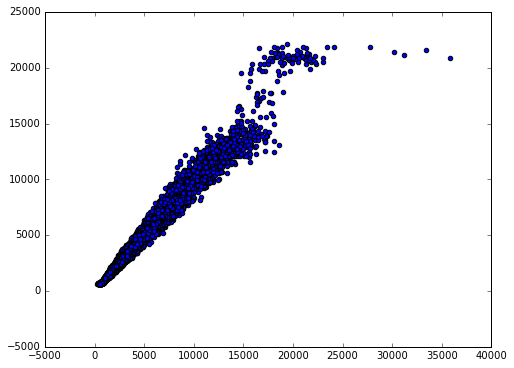

In [47]:
%pylab inline
pylab.figure(figsize=(8, 6))
pylab.scatter(s.loss, t.loss)

In [45]:
s[:3]

,id,loss
0,4,1532.770142
1,6,1836.772095
2,9,7915.705566


In [34]:
t = pd.DataFrame(t, columns = ['loss'])

In [37]:
ids = pd.DataFrame(test.id, columns = ['id'])
t = pd.concat([ids, t],axis=1)

In [49]:
t.loss = t.loss * 0.5 + s.loss * 0.5

In [50]:
t.to_csv('blend_boost_knn.csv', index=False)

In [51]:
t.isnull().sum()

id      0
loss    0
dtype: int64

## stack

In [26]:
forest = pd.DataFrame.from_csv("stack/forest_train.csv",index_col=None)
boost = pd.DataFrame.from_csv("stack/boost_train.csv",index_col=None)
knn2 = pd.DataFrame.from_csv("stack/knn2_train.csv",index_col=None)
knn4 = pd.DataFrame.from_csv("stack/knn4_train.csv",index_col=None)
knn8 = pd.DataFrame.from_csv("stack/knn8_train.csv",index_col=None)
knn16 = pd.DataFrame.from_csv("stack/knn16_train.csv",index_col=None)
knn32 = pd.DataFrame.from_csv("stack/knn32_train.csv",index_col=None)
knn64 = pd.DataFrame.from_csv("stack/knn64_train.csv",index_col=None)
knn128 = pd.DataFrame.from_csv("stack/knn128_train.csv",index_col=None)


In [27]:
X = pd.concat([forest, boost, knn2, knn4,knn8,knn16,knn32,knn64,knn128],axis=1)
X.columns = ['forest', 'boost', 'knn2', 'knn4', 'knn8', 'knn16', 'knn32', 'knn64', 'knn128']

In [28]:
X[:10]

,forest,boost,knn2,knn4,knn8,knn16,knn32,knn64,knn128
0,2226.930144,2053.978760,1821.680,3541.7900,2804.57125,2506.395000,2295.344687,2356.452344,2389.101875
1,1719.490149,1597.035522,1956.550,1899.3850,1733.68375,1806.850625,2112.318438,1966.004375,2012.620703
2,3655.906641,4514.017578,3700.795,4089.5225,4097.71250,5397.304375,5211.876562,5233.897187,4589.933437
3,1225.634112,1044.779541,1017.325,1447.4625,1230.86250,1199.775000,1204.549687,1247.163594,1343.451406
4,2957.094724,3048.395752,2556.565,6438.3000,6675.12125,6464.970625,6630.515625,6154.657812,5809.325391
5,4687.556035,3823.144043,7705.865,7757.3475,6000.45750,5322.044375,4513.060625,4825.690781,4846.687813
6,1459.540183,1151.560791,1278.945,1234.5275,1233.37500,1757.401250,2099.976875,2111.909219,2298.285781
7,5147.867464,5641.627930,614.525,4540.4325,4368.52000,4194.865000,4719.947812,5061.812344,4907.536953
8,7434.668233,8459.001953,6492.910,11513.8950,8724.92500,8454.581250,8510.685938,8295.238750,8213.524687
9,4630.942674,7310.999023,3751.265,6513.7500,5688.43500,5585.805625,5625.035313,5451.541250,5328.844063


In [29]:
param = {'min_child_weight': 100,
        'eta': 0.001,
        'colsample_bytree': 1.0,
        'max_depth': 5,
        'subsample': 1.0,
        #'alpha': 1,
        #'gamma': 1,
        #'silent': 1,
        'eval_metric' : 'mae',
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 2380
xgtrain = xgb.DMatrix(X, y)
bst = xgb.train(param, xgtrain, num_boost_round=num_round)

In [48]:
pd.DataFrame(bst.get_fscore().items()).sort_values(1, ascending=False)[:10]

,0,1
7,boost,40454
0,knn2,8293
3,forest,7590
4,knn32,2453
6,knn16,2286
8,knn8,2118
5,knn4,2007
1,knn64,1612
2,knn128,1406


In [19]:
%%time
param = {'min_child_weight': 100,
        'eta': 0.001,
        'colsample_bytree': 1.0,
        'max_depth': 5,
        'subsample': 1.0,
        #'alpha': 1,
        #'gamma': 1,
        #'silent': 1,
        'eval_metric' : 'mae',
        'objective': 'reg:linear',
        'verbose_eval': True}
num_round = 2380

xgtrain = xgb.DMatrix(X, y)

t = xgb.cv(param, xgtrain, num_boost_round=num_round, nfold=5, show_stdv=0, seed=0, verbose_eval=10)
#print t['test-mlogloss-mean'].min()
#print t['test-mlogloss-mean'].argmin() + 1

[0]	train-mae:3033.8	test-mae:3033.8
[10]	train-mae:3003.61	test-mae:3003.61
[20]	train-mae:2973.72	test-mae:2973.73
[30]	train-mae:2944.14	test-mae:2944.16
[40]	train-mae:2914.87	test-mae:2914.89
[50]	train-mae:2885.89	test-mae:2885.92
[60]	train-mae:2857.22	test-mae:2857.25
[70]	train-mae:2828.85	test-mae:2828.88
[80]	train-mae:2800.78	test-mae:2800.81
[90]	train-mae:2773.02	test-mae:2773.06
[100]	train-mae:2745.56	test-mae:2745.61
[110]	train-mae:2718.41	test-mae:2718.46
[120]	train-mae:2691.55	test-mae:2691.6
[130]	train-mae:2664.98	test-mae:2665.04
[140]	train-mae:2638.71	test-mae:2638.76
[150]	train-mae:2612.71	test-mae:2612.77
[160]	train-mae:2587.01	test-mae:2587.07
[170]	train-mae:2561.59	test-mae:2561.65
[180]	train-mae:2536.45	test-mae:2536.52
[190]	train-mae:2511.58	test-mae:2511.66
[200]	train-mae:2487	test-mae:2487.08
[210]	train-mae:2462.7	test-mae:2462.79
[220]	train-mae:2438.67	test-mae:2438.76
[230]	train-mae:2414.92	test-mae:2415.02
[240]	train-mae:2391.45	test-mae:2

KeyboardInterrupt: 

In [ ]:
6 - 1140
100 -1138

## Тест ctack

In [30]:
forest = pd.DataFrame.from_csv("stack/forest_test.csv",index_col=None)
boost = pd.DataFrame.from_csv("stack/boost_test.csv",index_col=None)
knn2 = pd.DataFrame.from_csv("stack/knn2_test.csv",index_col=None)
knn4 = pd.DataFrame.from_csv("stack/knn4_test.csv",index_col=None)
knn8 = pd.DataFrame.from_csv("stack/knn8_test.csv",index_col=None)
knn16 = pd.DataFrame.from_csv("stack/knn16_test.csv",index_col=None)
knn32 = pd.DataFrame.from_csv("stack/knn32_test.csv",index_col=None)
knn64 = pd.DataFrame.from_csv("stack/knn64_test.csv",index_col=None)
knn128 = pd.DataFrame.from_csv("stack/knn128_test.csv",index_col=None)


In [31]:
X = pd.concat([forest, boost, knn2, knn4,knn8,knn16,knn32,knn64,knn128],axis=1)
X.columns = ['forest', 'boost', 'knn2', 'knn4', 'knn8', 'knn16', 'knn32', 'knn64', 'knn128']

In [130]:
forest = pd.DataFrame.from_csv("stack/forest_test.csv",index_col=None)
boost = pd.DataFrame.from_csv("stack/boost_test.csv",index_col=None)
lin = pd.DataFrame.from_csv("stack/lin_test.csv",index_col=None)

In [131]:
X = pd.concat([forest, boost, lin],axis=1)
X.columns = ['forest', 'boost', 'lin']

In [122]:
dtrain = xgb.DMatrix(data = X, label = y)
bst = xgb.train(param, dtrain, num_round)

In [32]:
t = bst.predict(xgb.DMatrix(data = X))

In [33]:
t[:10]

array([ 1571.10119629,  2120.32592773,  8106.91259766,  6112.26611328,
         796.00994873,  2428.99584961,  2216.47363281,   860.95379639,
        2457.09741211,  3115.43701172], dtype=float32)

## Тест

In [36]:
test = pd.DataFrame.from_csv("test.csv",index_col=None)

In [14]:
test.shape

(125546, 131)

In [15]:
test_encode = test[["cat80","cat87","cat57","cat12","cat79","cat10","cat7","cat89","cat2","cat72", \
             "cat81","cat11","cat1","cat13","cat9","cat3","cat16","cat90","cat23","cat36", \
             "cat73","cat103","cat40","cat28","cat111","cat6","cat76","cat50","cat5", \
             "cat4","cat14","cat38","cat24","cat82","cat25"]]

In [16]:
test_encode = test.ix[:, 1:117]

In [16]:
test_encode = pd.get_dummies(test_encode[:])


In [17]:
#test_encode = le.transform(test_encode)

In [18]:
test_encode =  pd.concat([test_encode, test.ix[:, 117:131]],axis=1)

In [19]:
test_encode[:10]

,cat80_A,cat80_B,cat80_C,cat80_D,cat87_A,cat87_B,cat87_C,cat87_D,cat57_A,cat57_B,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,0,0,1,0,1,0,0,1,0,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,0,0,0,1,0,1,0,0,1,0,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,0,1,0,0,0,1,0,0,0,1,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,0,1,0,0,0,0,0,1,1,0,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,0,0,0,1,0,1,0,0,1,0,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
5,0,0,0,1,0,1,0,0,1,0,...,0.643315,0.407351,0.390540,0.46477,0.46853,0.50556,0.607500,0.594646,0.250991,0.283976
6,0,0,0,1,0,1,0,0,1,0,...,0.281143,0.960845,0.740081,0.75964,0.98330,0.82249,0.863052,0.879347,0.888944,0.787807
7,0,0,0,1,0,1,0,0,1,0,...,0.651246,0.451115,0.316313,0.27320,0.52100,0.50556,0.415029,0.481306,0.199940,0.450597
8,0,0,0,1,0,1,0,0,1,0,...,0.534484,0.343492,0.358758,0.81900,0.32128,0.36458,0.453334,0.443374,0.695650,0.295075
9,0,0,1,0,0,1,0,0,1,0,...,0.281143,0.394921,0.287416,0.92347,0.48320,0.24766,0.359572,0.352251,0.519989,0.602666


In [20]:
undef = []
for i in test_encode.columns.values:
    if i not in train_encode:
        undef += [i]

In [21]:
test_encode = test_encode.drop(undef, axis=1)

In [22]:
for i in train_encode.columns.values:
    if i in test_encode:
        test_encode.ix[:, i] = test_encode.ix[:, i]
    else:
        test_encode[i] = 0

In [23]:
test_encode.columns.unique().shape

(132,)

In [24]:
test_encode = test_encode.reindex_axis(sorted(test_encode.columns), axis=1)
test_encode[:10]

,cat103_A,cat103_B,cat103_C,cat103_D,cat103_E,cat103_F,cat103_G,cat103_H,cat103_I,cat103_J,...,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9
0,1,0,0,0,0,0,0,0,0,0,...,0.704052,0.392562,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365
1,1,0,0,0,0,0,0,0,0,0,...,0.453468,0.208045,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890
2,0,0,0,1,0,0,0,0,0,0,...,0.258586,0.297232,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365
3,0,0,0,1,0,0,0,0,0,0,...,0.592264,0.555955,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237
4,1,0,0,0,0,0,0,0,0,0,...,0.301535,0.825823,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731
5,0,0,1,0,0,0,0,0,0,0,...,0.250991,0.283976,0.245921,0.397983,0.849584,0.643315,0.407351,0.390540,0.46477,0.46853
6,0,1,0,0,0,0,0,0,0,0,...,0.888944,0.787807,0.620805,0.356819,0.838840,0.281143,0.960845,0.740081,0.75964,0.98330
7,1,0,0,0,0,0,0,0,0,0,...,0.199940,0.450597,0.047297,0.129646,0.864586,0.651246,0.451115,0.316313,0.27320,0.52100
8,1,0,0,0,0,0,0,0,0,0,...,0.695650,0.295075,0.245921,0.484196,0.463029,0.534484,0.343492,0.358758,0.81900,0.32128
9,1,0,0,0,0,0,0,0,0,0,...,0.519989,0.602666,0.488789,0.397983,0.775744,0.281143,0.394921,0.287416,0.92347,0.48320


In [28]:
boost_pred = bst.predict(xgb.DMatrix(data = test_encode))

NameError: name 'bst' is not defined

In [59]:
boost_pred = pd.DataFrame(boost_pred, columns = ['loss'])
boost_pred = np.exp(boost_pred)- 200
ids = pd.DataFrame(test.id, columns = ['id'])
boost_pred = pd.concat([ids, boost_pred],axis=1)

In [60]:
test_encode.shape

(125546, 132)

In [61]:
boost_pred.isnull().sum()

id      0
loss    0
dtype: int64

In [62]:
boost_pred.to_csv('boost_feat.csv', index=False)